<a href="https://colab.research.google.com/github/KevinYih/BigDataDemo/blob/main/Vietnam_War_test_Kevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spark Tutorial

In this tutorial, you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

Credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL.


### Setup

# Let's set up Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=415790a7f734d3aef9a2e8214776933d6226e704608b6b6ffcb9f84ed2c23fca
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Now, we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

In [5]:
!ls -l

total 65276
-rw-r--r-- 1 root root     2005 Jun  1 00:36 Aircraft_Glossary.json.gz
-rw-r--r-- 1 root root 66832932 Jun  1 00:36 Bombing_Operations.json.gz
drwxr-xr-x 1 root root     4096 May 30 13:36 sample_data


If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel.

In [6]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.


In [7]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [8]:
spark

# Vietnam War

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets:

In [9]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

Check the schema:

In [10]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [11]:
type(Bombing_Operations)

pyspark.sql.dataframe.DataFrame

In [12]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



Get a sample with `take()`:

In [ ]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

Get a formatted sample with `show()`:

In [13]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [14]:
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


## Question 1: Which countries are involved and in how many missions?

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Let's group the missions by `ContryFlyingMission` and count how many records exist:

In [ ]:
Bombing_Operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

In [ ]:
tmp1 = Bombing_Operations.groupBy("ContryFlyingMission").count().sort(desc("count"))
tmp1.show()

+--------------------+-------+
| ContryFlyingMission|  count|
+--------------------+-------+
|UNITED STATES OF ...|3708997|
|     VIETNAM (SOUTH)| 622013|
|                LAOS|  32777|
|       KOREA (SOUTH)|  24469|
|           AUSTRALIA|  12519|
+--------------------+-------+



In [ ]:
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_takeoff = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(countDistinct("TakeoffLocation").alias("MissionsTakeoff"))\
                                    .sort(desc("MissionsTakeoff"))
missions_counts.show()
missions_takeoff.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+

+--------------------+---------------+
| ContryFlyingMission|MissionsTakeoff|
+--------------------+---------------+
|UNITED STATES OF ...|             89|
|     VIETNAM (SOUTH)|             24|
|                LAOS|              7|
|       KOREA (SOUTH)|              3|
|           AUSTRALIA|              2|
+--------------------+---------------+



In this case we used the DataFrame API, but we could rewite the `groupBy` using pure SQL:

In [ ]:
Bombing_Operations.registerTempTable("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



The Dataframe is small enough to be moved to Pandas:

In [ ]:
missions_count_pd = missions_counts.toPandas()
missions_count_pd.head()

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Let's plot a barchart with the number of missions by country:

Text(0.5, 1.0, 'Number of missions by Country')

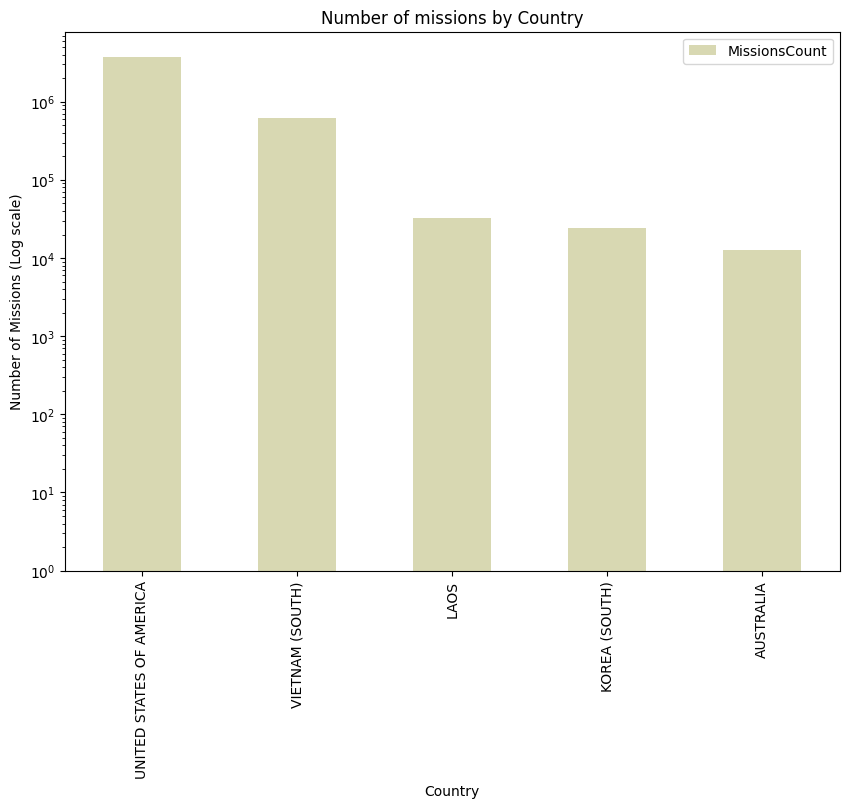

In [ ]:
pl = missions_count_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="MissionsCount",
                            figsize=(10, 7), log=True, alpha=0.3, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")

----

## Questions 2: Show the number of missions in time for each of the countries involved.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:

In [ ]:
missions_countries = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])
missions_countries.show()

+-----------+--------------------+
|MissionDate| ContryFlyingMission|
+-----------+--------------------+
| 1971-06-05|UNITED STATES OF ...|
| 1972-12-26|UNITED STATES OF ...|
| 1973-07-28|UNITED STATES OF ...|
| 1970-02-02|UNITED STATES OF ...|
| 1970-10-08|     VIETNAM (SOUTH)|
| 1970-11-25|UNITED STATES OF ...|
| 1972-03-08|UNITED STATES OF ...|
| 1971-12-27|UNITED STATES OF ...|
| 1972-05-24|UNITED STATES OF ...|
| 1972-09-12|UNITED STATES OF ...|
| 1974-06-13|UNITED STATES OF ...|
| 1974-12-19|UNITED STATES OF ...|
| 1973-10-24|     VIETNAM (SOUTH)|
| 1974-03-19|     VIETNAM (SOUTH)|
| 1970-05-08|UNITED STATES OF ...|
| 1971-05-12|UNITED STATES OF ...|
| 1971-12-03|UNITED STATES OF ...|
| 1971-12-19|                LAOS|
| 1972-08-18|UNITED STATES OF ...|
| 1972-10-15|UNITED STATES OF ...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
missions_countries.take(3)

[Row(MissionDate=datetime.date(1971, 6, 5), ContryFlyingMission='UNITED STATES OF AMERICA'),
 Row(MissionDate=datetime.date(1972, 12, 26), ContryFlyingMission='UNITED STATES OF AMERICA'),
 Row(MissionDate=datetime.date(1973, 7, 28), ContryFlyingMission='UNITED STATES OF AMERICA')]

The filed MissionDate is converted to a Python `date` object.

Now we can group by `MissionDate` and `ContryFlyingMission` to get the count:

In [ ]:
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate"))
missions_by_date.show()

+-----------+--------------------+-------------+
|MissionDate| ContryFlyingMission|MissionsCount|
+-----------+--------------------+-------------+
| 1965-10-01|UNITED STATES OF ...|          447|
| 1965-10-02|UNITED STATES OF ...|          652|
| 1965-10-03|UNITED STATES OF ...|          608|
| 1965-10-04|UNITED STATES OF ...|          532|
| 1965-10-05|UNITED STATES OF ...|          697|
| 1965-10-05|     VIETNAM (SOUTH)|           72|
| 1965-10-06|     VIETNAM (SOUTH)|           49|
| 1965-10-06|UNITED STATES OF ...|          689|
| 1965-10-07|UNITED STATES OF ...|          605|
| 1965-10-07|     VIETNAM (SOUTH)|           50|
| 1965-10-08|UNITED STATES OF ...|          700|
| 1965-10-08|     VIETNAM (SOUTH)|           64|
| 1965-10-09|     VIETNAM (SOUTH)|           69|
| 1965-10-09|UNITED STATES OF ...|          677|
| 1965-10-10|     VIETNAM (SOUTH)|           59|
| 1965-10-10|UNITED STATES OF ...|          789|
| 1965-10-11|     VIETNAM (SOUTH)|           48|
| 1965-10-11|UNITED 

Now we can plot the content with a different series for each country:

Bug here. We need move The Dataframe to Pandas before plotting.

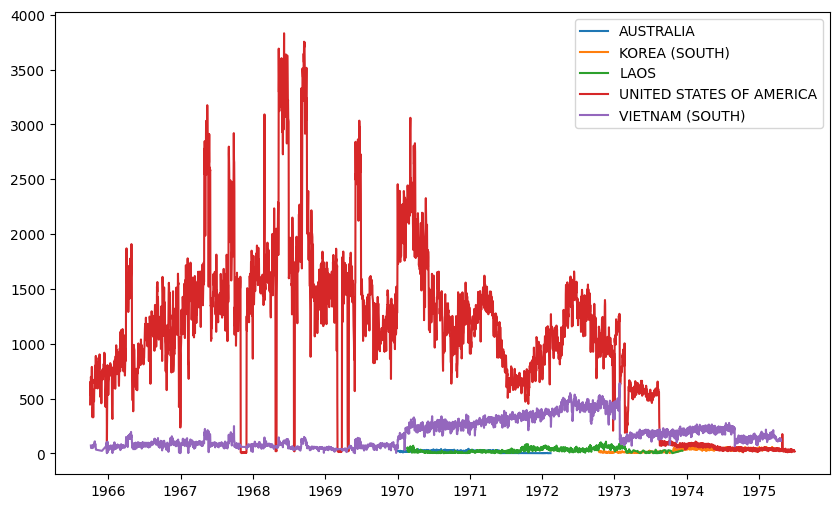

In [ ]:
missions_by_date_pd = missions_by_date.toPandas()
missions_by_date_pd.head()

fig = plt.figure(figsize=(10, 6))
# iterate the different groups to create a different series
for country, missions in missions_by_date_pd.groupby("ContryFlyingMission"):
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)


plt.legend(loc='best')


We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----

## Question 3: Who bombed this location?

Keywords: `RDD map reduce` `cache` `save results`

<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/Hanoi_POL1966.jpg">

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation.

We are interested in discovering what was the most common take-off location during that day.

In [ ]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM' AND WeaponType IS NOT NULL")
jun_29_operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|   F-105|UNITED STATES OF ...| 1966-06-29|       STEEL TIGER|          D|         TAKHLI|NORTH VIETNAM|       310.0|  1000LB MK-83|                 -1|
|     F-4|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          D|  CONSTELLATION|NORTH VIETNAM|       703.0| 2.75IN HE RKT|                 -1|
|   C-130|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          N|        UBON AB|NORTH VIETNAM|      1205.0|         MK-24|                 -1|
|     A-4|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          E|  CONSTE

Which coutries scheduled missions that day?

In [ ]:
jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),4
1,UNITED STATES OF AMERICA,230


Most of the operation that day were performed by USA airplanes.

In [ ]:
jun_29_operations.take(1)

[Row(AirCraft='F-105', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1966-06-29', OperationSupported='STEEL TIGER', PeriodOfDay='D', TakeoffLocation='TAKHLI', TargetCountry='NORTH VIETNAM', TimeOnTarget=310.0, WeaponType='1000LB MK-83', WeaponsLoadedWeight=-1)]

You can specify to cache the content in memory:

In [ ]:
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Now you can count the number of rows and move the content to the cache:

In [ ]:
%time jun_29_operations.count()

CPU times: user 113 ms, sys: 20.6 ms, total: 133 ms
Wall time: 14.7 s


234

The second time the content is cached and the operation is much faster:

In [ ]:
%time jun_29_operations.count()

CPU times: user 3.36 ms, sys: 0 ns, total: 3.36 ms
Wall time: 343 ms


234

You can also save the results on a file...

In [ ]:
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

... and read from the file:

In [ ]:
jun_29_operations = spark.read.json("jun_29_operations.json")

We can use the simple DataFrame API...

In [ ]:
TakeoffLocationCounts = jun_29_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           52|
|        UDORN AB|           36|
|         UBON AB|           36|
|           KORAT|           35|
|    TAN SON NHUT|           25|
|          TAKHLI|           20|
|          RANGER|           13|
|          DANANG|           12|
|HANCOCK (CVA-19)|            5|
+----------------+-------------+



... or the explicit Map/Reduce format with RDDs.

First we emit a pair in the format (Location, 1):

In [ ]:
all_locations = jun_29_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

[('TAKHLI', 1), ('CONSTELLATION', 1), ('UBON AB', 1)]

In [ ]:
type(all_locations)

pyspark.rdd.PipelinedRDD

Then, we sum counters in the reduce step, and we sort by count:

In [ ]:
locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])

type(locations_counts_rdd)
locations_counts_rdd.take(3)

[('CONSTELLATION', 52), ('UBON AB', 36), ('UDORN AB', 36)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [ ]:
locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           52|
|         UBON AB|           36|
|        UDORN AB|           36|
|           KORAT|           35|
|    TAN SON NHUT|           25|
|          TAKHLI|           20|
|          RANGER|           13|
|          DANANG|           12|
|HANCOCK (CVA-19)|            5|
+----------------+-------------+



<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates. Next steps: explore TimeOnTarget feature.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

----

## Questions 4: What is the most used aircraft type during the Vietnam war (number of missions)?

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`:

In [ ]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



We are interested in the filed `AirCraftType`.

In [ ]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows



We can join on the column `AirCraft` of both dataframes.

With Dataframe API:

In [ ]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary,
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

We can select only the field we are interested in:

In [ ]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



And finally we can group by `AirCraftType` and count:

In [ ]:
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



In alternative we can rewrite this in pure SQL:

In [17]:
Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

aircraft_type_missions = spark.sql(query)
aircraft_type_missions.toPandas()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


,AirCraftType,MissionsCount
0,Fighter Jet Bomber,1073126
1,Fighter Jet,882594
2,Jet Fighter Bomber,451385
3,Attack Aircraft,315246
4,Light ground-attack aircraft,267457
5,Fighter bomber jet,242231
6,Military Transport aircraft,228426
7,Utility Helicopter,146653
8,Strategic bomber,99100
9,Tactical Bomber,82219


The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`

## Questions 5: What types of missions were carried out during the Vietnam war (for each category produce the number of missions)?

This is a question that requires you to interpret the data. There is no explicit column about the type of mission in the dataset. One way to answer the question is to look at the aircraft type or whether there was any weapon loaded during the mission, and draw conclusions about the type of mission. Produce three to five categories.

In [23]:
# your code here

Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT
    AirCraftType,
    count(*) AS TotalMission,
    count(*)-count(WeaponType) AS UnarmedMission,
    count(WeaponType) AS ArmedMission
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY AirCraftType;
"""

type_missions = spark.sql(query)
type_missions.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


,AirCraftType,TotalMission,UnarmedMission,ArmedMission
0,Aerial refuelling aircraft,8266,8266,0
1,Airborne early warning and control,17226,17222,4
2,Airliner/ Transport,1,1,0
3,Airliner/transport aircraft,397,259,138
4,Attack Aircraft,315246,195350,119896
5,Bomber Jet,8,3,5
6,Cargo Helicopter,2571,490,2081
7,Cargo Prop plane,176,117,59
8,Carrier-base all-weather night Fighter Jet,2,2,0
9,Carrier-based Early Warning aircraft,1498,1497,1
